# Image recognition with TTR


In [1]:
import sys
sys.path.append('pyttr')
from pyttr.ttrtypes import *
from pyttr.utils import *
import PIL.Image

In [2]:
Ind = BType('Ind')

## Utilities & PyTTR additions

In [3]:
# Can be called with multiple args *at the end* of a code block to illustrate PyTTR types and objects.
def latex(*objs):
    texcode = '\n\n'.join(to_ipython_latex(obj) for obj in objs)
    #print(texcode) # Uncomment to get LaTeX source.
    return Latex(texcode)

# Redefine Image.show() to work with Rec.show().
def image_show(self):
    return str(self)
PIL.Image.Image.show = image_show

### Custom PyTTR utilities

Several changes have also been made inside the PyTTR lib, regarding relabeling, subst and latex. They currently live on separate branches at https://github.com/arildm/pyttr.

In [4]:
from functools import reduce
    
def copy_rectype(T):
    """Make another copy of a record type."""
    R = RecType()
    for k, v in T.comps.__dict__.items():
        R.addfield(k, v)
    return R

def rectype_relabels(T, rlbs):
    """Relabel multiple fields, given a dict of from-to pairs."""
    for k1, k2 in rlbs.items():
        T.Relabel(k1, k2)
    return T

def rectype_merges(Ts):
    """Merge a list of RecTypes."""
    return reduce((lambda T, U: T.merge(U)), Ts, RecType())

def is_basic_type(T):
    """Whether a type is a "basic field", i.e. a BType or a SingletonType of a BType."""
    tn = lambda T: type(T).__name__
    return (tn(T) == 'BType') if tn(T) != 'SingletonType' else is_basic_type(T.comps.base_type)

def basic_fields(T):
    """The labels of basic fields in a RecType."""
    return [k for k, v in T.comps.__dict__.items() if is_basic_type(v)]

def nonbasic_fields(T):
    """The labels of non-basic fields in a RecType."""
    return [k for k, v in T.comps.__dict__.items() if not is_basic_type(v)]

In [5]:
ptypes = dict()
def mkptype(sym, types=[Ind], vars=['v']):
    """Make preds and ptypes identifiable by their predicate names."""
    id = '/'.join([sym, ','.join(show(type) for type in types), ','.join(vars)])
    if id not in ptypes:
        ptypes[id] = PType(Pred(sym, types), vars)
    return ptypes[id]

def create_fun(pred_name, vars=['a']):
    """Create a function of a given number of Inds (length of vars).
    
    Example: create_fun('give', 'abc') --> \a. \b. \c. give(a, b, c)
    """
    fun = mkptype(pred_name, types=[Ind]*len(vars), vars=vars)
    for v in reversed(vars):
        fun = Fun(v, Ind, fun)
    return fun

latex(create_fun('give', 'abc'))

<IPython.core.display.Latex object>

In [6]:
def unique_labels(T):
    """Relabel a RecType so each field label is unique over all RecTypes."""
    for l, v in T.comps.__dict__.items():
        if '_' not in l:
            T.Relabel(l, gensym(l))
    return T

def merge_unconflict(T1, T2):
    """Merge two RecTypes after making sure they do not share any field labels."""
    T1c = unique_labels(copy_rectype(T1))
    T2c = unique_labels(copy_rectype(T2))
    return T1c.merge(T2c)

T1 = RecType({'x': Ind})
T2 = RecType({'x': Ind})
latex(T1, T2, merge_unconflict(T1, T2))

<IPython.core.display.Latex object>

In [7]:
def use_ind_field_labels(T):
    """c:foo(a) becomes c:foo(x) if x=a:Ind is present."""
    T = copy_rectype(T)
    for l, v in T.comps.__dict__.items():
        if isinstance(v, SingletonType) and v.comps.base_type == Ind:
            a = v.comps.obj
            T.Relabel(a, l)
            # Undo the relabeling of the Ind field itself.
            T.comps.__dict__[l] = SingletonType(Ind, a)
    return T

T = RecType({'x': SingletonType(Ind, 'a'), 'c': create_fun('foo').app('a')})
latex(T, use_ind_field_labels(T))

<IPython.core.display.Latex object>

In [8]:
def singleton_rectype_to_rec(T):
    """From a fully specified RecType, create the record that belongs to it."""
    for v in T.comps.__dict__.values():
        if not isinstance(v, SingletonType):
            raise ValueError('All fields must be singleton types.')
    return T.create()

def unsingleton(T):
    """Remove singleton specifications of a type: x=a:Ind becomes x:Ind."""
    T2 = RecType()
    for l, v in T.comps.__dict__.items():
        T2.addfield(l, v if not isinstance(v, SingletonType) else v.comps.base_type)
    return T2

T = RecType({'x': SingletonType(Ind, 'a')})
latex(T, singleton_rectype_to_rec(T), unsingleton(T))

<IPython.core.display.Latex object>

# Types

$Ind$ and $Image$ are basic types.

$Segment = \left[\begin{array}{rcl}
\text{cx} &:& Int\\
\text{cy} &:& Int\\
\text{w} &:& Int\\
\text{h} &:& Int\\
\end{array}\right]$

$Ppty = (Ind \rightarrow Type)$

$Obj = \left[ \begin{array}{rcl}
    \text{pfun} &:& Ppty \\
    \text{seg} &:& Segment \\
\end{array} \right]$

$ObjDetector = ( Image \rightarrow [Obj] )$

$IndFun = ( Obj \rightarrow RecType )$

## Bridging between perceptual and conceptual domains

Let's apply the object detection representation proposed in Dobnik & Cooper's *Interfacing language, spatial perception and cognition in TTR* to image recognition.

![Fig 8](fig/lspc-fig8.png)

Here, we use `Image` instead of `PointMap` for the whole, but instead of `reg:PointMap` we use yet another type (and rename it), `seg:Segment`. In Cooper's case the same type can be used to represent both the region and the whole, because a `PointMap` is a set of absolute positions. With `Image`, positions are relative to an origin, which needs to be specified when cropping.

I guess in the general case, the domain of an `ObjectDetector` function need not be the same as the `reg` fields in the output elements.

In [9]:
# More basic types.

Int = BType('Int')
Int.learn_witness_condition(lambda x: isinstance(x, int))
print(Int.query(365))

Image = BType('Image')
Image.learn_witness_condition(lambda x: isinstance(x, PIL.Image.Image))
img = PIL.Image.open('res/dogride.jpg') # https://www.flickr.com/photos/hickatee/34017375600
print(Image.query(img))

# Segment type: a rectangular area of a given image.

Segment = RecType({'cx': Int, 'cy': Int, 'w': Int, 'h': Int})
print(Segment.query(Rec({'cx': 100, 'cy': 150, 'w': 40, 'h': 20})))

True
True
True


In [10]:
Ppty = FunType(Ind, Ty)
Obj = RecType({'seg': Segment, 'pfun': Ppty})
Objs = ListType(Obj)
ObjDetector = FunType(Image, Objs)

latex(Segment, Ppty, ObjDetector)

<IPython.core.display.Latex object>

## Object detection model YOLO

We use an object detection model to detect and recognize objects in an image. The output is modeled as a set of TTR records.

Requires OpenCV and [Darkflow](https://github.com/thtrieu/darkflow). `yolo.weights` is from [Yolo](https://pjreddie.com/darknet/yolo/).

In [11]:
# Instantiate YOLO.

from darkflow.net.build import TFNet

tfnet = TFNet({"model": "yolo/yolo.cfg", "load": "yolo/yolo.weights",
    'config': 'yolo', "threshold": 0.2})

Parsing yolo/yolo.cfg
Loading yolo/yolo.weights ...
Successfully identified 203934260 bytes
Finished in 0.04169583320617676s
Model has a coco model name, loading coco labels.

Building net ...
Source | Train? | Layer description                | Output size
-------+--------+----------------------------------+---------------
       |        | input                            | (?, 608, 608, 3)
 Load  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 608, 608, 32)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 304, 304, 32)
 Load  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 304, 304, 64)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 152, 152, 64)
 Load  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 152, 152, 128)
 Load  |  Yep!  | conv 1x1p0_1  +bnorm  leaky      | (?, 152, 152, 64)
 Load  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 152, 152, 128)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 76, 76, 128)
 Load  |  Yep!  | conv 3x3p1_1  +bn

In [12]:
# Function to apply YOLO to a given image.

import numpy as np

yolo_out = dict()
def yolo(img):
    """Invokes YOLO on a PIL image, caches and returns the result."""
    if str(img) not in yolo_out:
        yolo_out[str(img)] = tfnet.return_predict(np.array(img))
    return yolo_out[str(img)]

def yolo_coords(o):
    """Extract the coordinates from a YOLO output item as ((x0,y0), (x1,y1))."""
    return (o['topleft']['x'], o['topleft']['y']), (o['bottomright']['x'], o['bottomright']['y'])

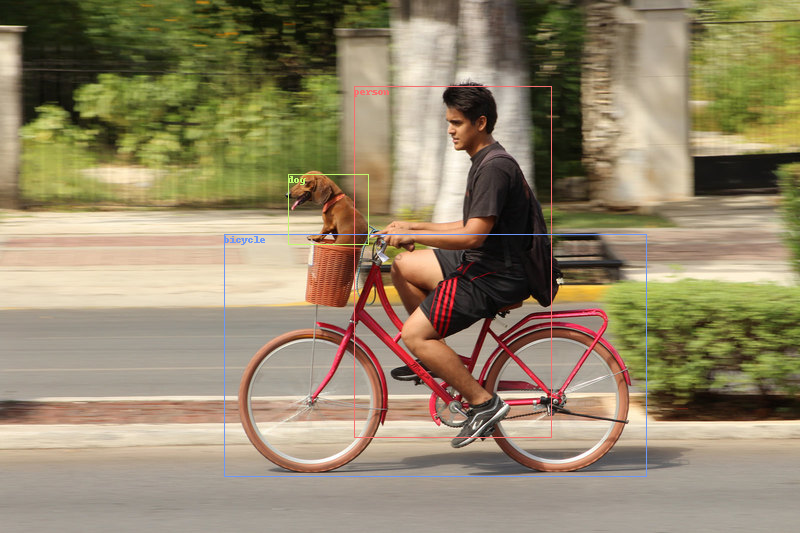

In [13]:
from PIL import ImageFont, ImageDraw
from IPython.display import display

# Generate distinguishable colors.
phi = 2 / (1 + 5 ** .5)
colors = ('hsl({}, 90%, 70%)'.format(int(x * 360)) for x in count(0, phi))

def yolo_annotate(img):
    """Displays the image with YOLO results annotated."""
    img_annotated = img.copy()
    draw = ImageDraw.Draw(img_annotated)
    for o in yolo(img):
        color = next(colors)
        draw.rectangle(yolo_coords(o), outline=color)
        draw.text(yolo_coords(o)[0], o['label'], fill=color)
    display(img_annotated)
    
yolo_annotate(img)
# Modified image under licence CC-by-nc-sa: https://creativecommons.org/licenses/by-nc-sa/2.0/

In [14]:
# Representing detected objects in TTR.

def xy1xy2_to_cwh(x1, y1, x2, y2):
    '''Transform to center, width and height.'''
    return {'cx': int(x1/2 + x2/2), 'cy': int(y1/2 + y2/2), 'w': x2 - x1, 'h': y2 - y1}

def yolo_detector(i):
    """Creates IndObj records for YOLO results."""
    return [Rec({
        'seg': Rec(xy1xy2_to_cwh(*yolo_coords(o)[0], *yolo_coords(o)[1])),
        'pfun': create_fun(o['label'].replace(' ', '_')),
    }) for o in yolo(i)] # @todo RBG/BGR?
ObjDetector.witness_cache.append(yolo_detector)

objs = yolo_detector(img)

print(ObjDetector.query(yolo_detector))
print(Objs.query(objs))
print(Obj.query(objs[0]))
print(Ppty.query(objs[0].pfun))
print(Segment.query(objs[0].seg))

latex(objs)

True
True
True
True
True


<IPython.core.display.Latex object>

## Individuation function

The object detection model gave us evidence that certain segments contain something that present certain properties/classes.

Now let's recognize that there are individuals which are located at those segments and having those properties. ("Basic relationships" in Logan & Sadler (1996)).

$IndObj = \left[\begin{array}{rcl}
\text{x} &:& Ind\\
\text{cp} &:& Type\\
\text{cl} &:& \text{location}(\text{x}, \text{loc})\\
\text{loc} &:& Segment\\
\end{array}\right]$

$Individuate : IndFun$

$IndFun = (Obj \rightarrow RecType)$

$Individuate = \lambda r : Obj\ . \left[\begin{array}{lcl}
    \text{x} = a_0 &:& Ind \\
    \text{cp} = e_0 &:& r.\text{pfun}(\text{x}) \\
    \text{cl} = e_1 &:& \text{location}(\text{x}, \text{loc}) \\
    \text{loc} = r.\text{seg} &:& Segment\\
\end{array}\right]$

In [15]:
PTy = Type('PTy')
PTy.learn_witness_condition(lambda p: isinstance(p, HypObj) \
    and forsome(p.types, lambda t: isinstance(t, PType)))

IndObj = RecType({
    'x' : Ind,
    'loc' : Segment,
    'cp' : PTy,
    'cl' : create_fun('location', 'ab').app('x').app('loc'),
})
IndFun = FunType(Obj, RecTy)

def individuate(r):
    cp = r.pfun.app('x')
    cl = create_fun('location', 'ab').app('x').app('loc')
    return RecType({
        'x': SingletonType(Ind, Ind.create()),
        'cp': SingletonType(cp, cp.create()),
        'loc': SingletonType(Segment, r.seg),
        'cl': SingletonType(cl, cl.create()),
    })
IndFun.witness_cache.append(individuate)


indobjs = [individuate(r) for r in objs]
print(indobjs[0].comps.cp.comps.base_type.witness_cache)
print(indobjs[0].comps.cp.comps.obj)
print(indobjs[0].comps.cp.query(indobjs[0].comps.cp.comps.obj))

print(Obj.query(objs[1]))
print(RecTy.query(indobjs[1]))
print(unsingleton(indobjs[1]).subtype_of(IndObj))
latex(indobjs)

['e_{0}']
e_{0}
True
True
True
True


<IPython.core.display.Latex object>

## Spatial relations

Classify two $IndObj$s as $\text{left}$:

$TrgRef = \left[\begin{array}{rcl}
    \text{trg} &:& IndObj \\
    \text{ref} &:& IndObj \\
\end{array}\right]$

$ClfRes = \left[\begin{array}{rcl}\text{cr} &:& Type \end{array}\right]$

$Clf = (TrgRef \rightarrow ClfRes)$ or $(TrgRef \rightarrow Type_{ClfRes})$?

For some classifier $\kappa$ and predicate $pred$,

$\lambda r : TrgRef .
\begin{cases}
\left[\begin{array}{lcl}
    \text{cr} &:& pred(r.\text{trg}.\text{x}, r.\text{ref}.\text{x})\\
\end{array}\right]
&
\begin{array}{l}
    \text{if } \kappa(r.\text{trg}.\text{loc}, r.\text{ref}.\text{loc}) \\
\end{array}\\
[] & \text{otherwise}
\end{cases}
$

In [16]:
from itertools import product

LocTup = RecType({'lo': IndObj, 'refo': IndObj})
ClfRes = RecType({'cr': PTy})
RelClf = FunType(LocTup, ClfRes)

location_relation_classifiers = {
    'left': lambda a, b: a.cx < b.cx,
    'right': lambda a, b: a.cx > b.cx,
    'above': lambda a, b: a.cy < b.cy,
    'below': lambda a, b: a.cy > b.cy,
}

def get_relclfs():
    for pred, f in location_relation_classifiers.items():
        def relclf(r):
            if f(r.lo.loc, r.refo.loc):
                c = create_fun(pred, 'ab').app(r.lo.x).app(r.refo.x)
                return RecType({'cr': SingletonType(c, c.create())})
            return RecType()
        RelClf.witness_cache.append(relclf)
        yield relclf

def find_all_rels(indobjs):
    """Find all relations between IndObj records."""
    for relclf in get_relclfs():
        for loT, refoT in product(indobjs, indobjs):
            loctup = Rec({'lo': loT.create(), 'refo': refoT.create()})
            yield relclf(loctup)

rels = list(find_all_rels(indobjs))

latex(rels)

<IPython.core.display.Latex object>

## Combining commitments

We have now observed basic relation situations ($IndObj$s) as well as deictic relation situations (binary spatial relations). They are now combined into one, so they can be considered simultaneously.

In [17]:
def combine_beliefs(bel):
    """Combine a list of belief record types into one."""
    return unsingleton(use_ind_field_labels(reduce(merge_unconflict, bel, RecType())))

bel = indobjs + rels
bel_comb = combine_beliefs(bel)
latex(bel_comb)

<IPython.core.display.Latex object>

## Text parsing

In [18]:
import nltk

# Parsing to PyTTR cannot really be done directly. NLTK feature grammars support strings and FOPC. Variable substitution
# is only allowed in FOPC. We produce a FOPC conjunction of ptypes, for each of which we create a new field.
grammar = nltk.grammar.FeatureGrammar.fromstring(r'''
%start S
S[SEM=<?s(x) & ?vp(x, y)>] -> NP[SEM=?s] VP[SEM=?vp]
NP[SEM=<?det(?n)>] -> Det[SEM=?det] N[SEM=?n]
Det[SEM=<\P a.P(a)>] -> 'a' | 'an'
N[SEM=<dog>] -> 'dog'
N[SEM=<car>] -> 'car'
N[SEM=<person>] -> 'person'
N[SEM=<bicycle>] -> 'bicycle'
N[SEM=<backpack>] -> 'backpack'
VP[SEM=?pp] -> 'is' PP[SEM=?pp]
PP[SEM=<\a b.(?prep(a, b) & ?o(b))>] -> Prep[SEM=?prep] NP[SEM=?o]
Prep[SEM=<left>] -> 'to' 'the' 'left' 'of'
Prep[SEM=<right>] -> 'to' 'the' 'right' 'of'
Prep[SEM=<above>] -> 'above'
Prep[SEM=<under>] -> 'under'
''')
parser = nltk.FeatureChartParser(grammar)

texts = [
    'A dog is to the left of a bicycle',
]

def fopc_to_pyttr(expr, T=RecType()):
    """Turns a FOPC object into a RecType."""
    from nltk.sem.logic import ApplicationExpression, AndExpression
    if isinstance(expr, ApplicationExpression):
        pred, args = expr.uncurry()
        T.addfield(gensym('c'), mkptype(str(pred), vars=[str(a) for a in args]))
        for x in args:
            if str(x) not in T.comps.__dict__:
                T.addfield(str(x), Ind)
    if isinstance(expr, AndExpression):
        fopc_to_pyttr(expr.first, T)
        fopc_to_pyttr(expr.second, T)
    return T

def eng_to_pyttr(text):
    trees = parser.parse(text.lower().split())
    sem = nltk.sem.root_semrep(list(trees)[0])
    T = fopc_to_pyttr(sem)
    return T

print(texts[0])
q = eng_to_pyttr(texts[0])
latex(q)

A dog is to the left of a bicycle


<IPython.core.display.Latex object>

## Checking text against image

Essentially, we would like to check if the situation observed is a subtype of the situation described by the text/question, whether $Q \sqsupseteq A$. A new problem here is that field labels do not match, even if the field values (the types) match. We thus need to consider all (?) relabelings of Q:

A record type $T_1$ is a *relabel-subtype* of $T_2$ if there is a relabeling of $T_1$, $T_{1_{rlb}}$ where $T_{1_{rlb}} \sqsubseteq T_2$.

Could we forget field labels and just look at the two sets of field values? Not really, because we have dependent types, so $\text{dog}(x_1) ≠ \text{dog}(x_2)$. We need to carry out each candidate *relabeling* and check subtypeness. In practice, and in this case, relabeling the basic-type ($Ind$) fields is enough, because those are the only ones whose labels appear in dependent fields. For each basic-field relabeling, we can then kind of forget labels and just find subtypeness of field values.

In [19]:
from itertools import permutations, combinations

def find_subtype_relabeling(T, U):
    '''Could record type T be a sub type of record type U if relabeling in T is allowed?'''
    # Find possible relabelings for basic-type fields
    basic_label_permutations = set(ps[:len(basic_fields(U))] for ps in permutations(basic_fields(T)))
    
    for tks in basic_label_permutations:
        # Copy U and try a basic-fields relabeling
        U2 = copy_rectype(U)
        rlb = dict(zip(basic_fields(U), tks))
        rectype_relabels(U2, rlb)
        
        # For each U field, find a T field that is a subtype
        match = dict()
        for uk in nonbasic_fields(U2):
            for tk in nonbasic_fields(T):
                if T.comps.__dict__[tk].subtype_of(U2.comps.__dict__[uk]):
                    match[uk] = tk
                    break
            if uk not in match:
                break

        # Successful if all non-basic fields match.
        if len(match) == len(nonbasic_fields(U2)):
            return dict(**rlb, **match)
    return None

In [20]:
def validate_utt(utt, bel):
    return bool(find_subtype_relabeling(combine_beliefs(bel), utt))

def relabel_utt(utt, bel_comb):
    """Relabels an utterance record type to match the combined beliefs.
    
    The result will be a subtype of bel_comb.
    """
    rlb = find_subtype_relabeling(bel_comb, utt)
    return rectype_relabels(utt, rlb)

print(validate_utt(q, bel))
latex(relabel_utt(q, bel_comb))

True


<IPython.core.display.Latex object>

# Agent state

We are building an agent who receives classified and located objects of an image, apprehends their basic status and spatial relations, and validates natural-language propositions.

The agent state is of the type $State$. It contains sensory input records, belief rectypes and apprehension functions that can create new beliefs. Our agent begins as $ag$.

$Agent = \left[\begin{array}{rcl}
    \text{objdetector} &:& ObjDetector \\
    \text{indfun} &:& IndFun \\
    \text{appr} &:& [(Rec \rightarrow RecType)] \\
    \text{state} &:& State \\
    \end{array}\right]$

$State = \left[\begin{array}{rcl}
    \text{img} &:& Image \\
    \text{perc} &:& [Obj] \\
    \text{bel} &:& [RecType] \\
    \text{utt} &:& RecType \\
    \end{array}\right]$
    
$ag = \left[\begin{array}{rcl}
    \text{objdetector} &=& \mathtt{yolo}\_\mathtt{detector} \\
    \text{indfun} &=& \mathtt{individuate} \\
    \text{appr} &=& [C_{left}, C_{right}, ...] \\
    \text{state} &=& \left[\begin{array}{rcl}
        \text{img} &=& \mathtt{<dogride.jpg>} \\
        \text{perc} &=& [\left[\begin{array}{rcl}
            \text{pfun} &=& \lambda a . \text{dog}(a) \\
            \text{seg} &=& [...]
            \end{array}\right], ...] \\
        \text{bel} &=& [\left[\begin{array}{lcl}
            \text{x}=a_0 &:& Ind \\
            \text{loc}=[...] &:& Segment \\
            \text{cp}=e_0 &:& \text{dog}(\text{x}) \\
            \text{cl}=e_1 &:& \text{location}(\text{x}, \text{loc}) \\
            \end{array}\right], ...] \\
        \end{array}\right] \\
    \end{array}\right] : Agent$
    
where

$C_{left} : RelClf$

$RelClf = ( LocTup \rightarrow RecType )$

$LocTup = \left[\begin{array}{rcl}
    \text{lo} &:& IndObj \\
    \text{refo} &:& IndObj \\
    \end{array}\right]$


* perc: A queue of perceptions. They can be of different types depending on sense, for vision they could be Obj.
* appr: A list of cognitive processes available to the agent. They are functions, applied to objects in *perc* and *bel* according to arity and type, and they produce beliefs.
* bel: An accumulation of beliefs created by cognitive processes in *appr*.

Sensory-cognitive procedure:
1. Get sensory input, create Recs and add to perc
2. Automatically individuate() the Recs in perc, create RecTypes and add to bel
3. Iterate over appr, apply functions to any beliefs that fit the function type. Add any resulting commitments to bel.

Linguistic procedure:
1. Receive utterance and parse to TTR
2. Combine all beliefs into one type
3. Label-insensitive subtype check

In my case:
1. Invoke YOLO, create &lt;pfun, seg> Recs and add to *perc*
2. individuate() the Recs, create &lt;x, cp, loc, cl> (IndObj) RecTypes and add to bel
3. In appr there's spatial relation classifiers, invoke them to create new beliefs
4. Parse utterance to TTR, combine beliefs and check subtypeness.